# 修改 YOLO 框架使其支持全角度

**注意：**这个修改对于本项目**不是必须**的，只是提供一个思路尝试让原版YOLO-OBB模型支持全角度预测。

**Note:** This modification is **not** required for this project. It just provides an idea to try to make the original YOLO-OBB model support full-angle prediction.

如果你想使用此**一阶段模型**实现全角度预测，你需要注意：
- 即使经过以下修改，模型依旧也只能预测0°~180°，无法实现全角度预测。
- 对于输出角向量的方案，简单的修改下，模型完全无法正常收敛，需要修改整个输出头和损失计算过程。
- 本项目仅限工程上主观验证，欢迎进行更加量化、更加系统的验证。

更新：使用角向量彻底不回归了（悲


In [ ]:
import torch
import numpy as np
import cv2
import math

from typing import List, Tuple, Union
import torch.nn as nn
from ultralytics.nn.modules import Detect, Conv
from ultralytics.utils.tal import dist2rbox
from ultralytics.utils.loss import v8DetectionLoss, RotatedBboxLoss
from ultralytics.utils.tal import RotatedTaskAlignedAssigner, make_anchors
from typing import Any, Dict

## 修改检测框格式转换并关闭边界采样

utils/ops.py


In [7]:
def xyxyxyxy2xywhr_old(x):
    """
    Convert batched Oriented Bounding Boxes (OBB) from [xy1, xy2, xy3, xy4] to [xywh, rotation] format.

    Args:
        x (np.ndarray | torch.Tensor): Input box corners with shape (N, 8) in [xy1, xy2, xy3, xy4] format.

    Returns:
        (np.ndarray | torch.Tensor): Converted data in [cx, cy, w, h, rotation] format with shape (N, 5).
            Rotation values are in radians from 0 to pi/2.
    """
    is_torch = isinstance(x, torch.Tensor)
    points = x.cpu().numpy() if is_torch else x
    points = points.reshape(len(x), -1, 2)
    rboxes = []
    for pts in points:
        # NOTE: Use cv2.minAreaRect to get accurate xywhr,
        # especially some objects are cut off by augmentations in dataloader.
        (cx, cy), (w, h), angle = cv2.minAreaRect(pts)
        rboxes.append([cx, cy, w, h, angle / 180 * np.pi])
    return torch.tensor(rboxes, device=x.device, dtype=x.dtype) if is_torch else np.asarray(rboxes)


def xyxyxyxy2xywhr(x):
    """
    Convert batched Oriented Bounding Boxes (OBB) from [xy1, xy2, xy3, xy4] to [xywh, rotation] format.

    四个点按照逆时针顺序排列
    1. 规定pt1为右下角, pt2为右上角, pt3为左上角, pt4为左下角，pt1和pt2组成的边是图像的顶部
    2. 规定指向图像右侧方向为0°，顺时针方向为正角度，范围在-180°~180°

    Args:
        x (np.ndarray | torch.Tensor): Input box corners with shape (N, 8) in [xy1, xy2, xy3, xy4] format.

    Returns:
        (np.ndarray | torch.Tensor): Converted data in [cx, cy, w, h, rotation] format with shape (N, 5).
            Rotation values are in radians from -pi to pi.
    """
    is_torch = isinstance(x, torch.Tensor)
    points = x.cpu().numpy() if is_torch else x
    points = points.reshape(len(x), -1, 2)
    rboxes = []
    for pts in points:
        cx = np.mean(pts[:, 0])
        cy = np.mean(pts[:, 1])
        pt1, pt2, pt3, pt4 = pts  # 假定检测框都是矩形
        w = np.sqrt(np.sum((pt2 - pt3) ** 2))
        h = np.sqrt(np.sum((pt4 - pt3) ** 2))
        angle = np.arctan2((pt1-pt4)[1], (pt1-pt4)[0])
        rboxes.append([cx, cy, w, h, angle])

    return torch.tensor(rboxes, device=x.device, dtype=x.dtype) if is_torch else np.asarray(rboxes)

In [9]:
def resample_segments_old(segments, n: int = 1000):
    """
    Resample segments to n points each using linear interpolation.

    Args:
        segments (list): List of (N, 2) arrays where N is the number of points in each segment.
        n (int): Number of points to resample each segment to.

    Returns:
        (list): Resampled segments with n points each.
    """
    for i, s in enumerate(segments):
        if len(s) == n:
            continue
        s = np.concatenate((s, s[0:1, :]), axis=0)
        x = np.linspace(0, len(s) - 1, n - len(s) if len(s) < n else n)
        xp = np.arange(len(s))
        x = np.insert(x, np.searchsorted(x, xp), xp) if len(s) < n else x
        segments[i] = (
            np.concatenate([np.interp(x, xp, s[:, i])
                           for i in range(2)], dtype=np.float32).reshape(2, -1).T
        )  # segment xy
    return segments


def resample_segments(segments, n: int = 1000):
    """
    Resample segments to n points each using linear interpolation.

    针对OBB的采样将跳过

    Args:
        segments (list): List of (N, 2) arrays where N is the number of points in each segment.
        n (int): Number of points to resample each segment to.

    Returns:
        (list): Resampled segments with n points each.
    """
    return segments

In [10]:
def regularize_rboxes_old(rboxes):
    """
    Regularize rotated bounding boxes to range [0, pi/2].

    Args:
        rboxes (torch.Tensor): Input rotated boxes with shape (N, 5) in xywhr format.

    Returns:
        (torch.Tensor): Regularized rotated boxes.
    """
    x, y, w, h, t = rboxes.unbind(dim=-1)
    # Swap edge if t >= pi/2 while not being symmetrically opposite
    swap = t % math.pi >= math.pi / 2
    w_ = torch.where(swap, h, w)
    h_ = torch.where(swap, w, h)
    t = t % (math.pi / 2)
    return torch.stack([x, y, w_, h_, t], dim=-1)  # regularized boxes


def regularize_rboxes(rboxes):
    """
    Regularize rotated bounding boxes to range [0, pi/2].

    Args:
        rboxes (torch.Tensor): Input rotated boxes with shape (N, 5) in xywhr format.

    Returns:
        (torch.Tensor): Regularized rotated boxes.
    """
    return rboxes

## 修改模型检测头以支持向量输出

nn/modules/head.py


In [13]:
class OBB_old(Detect):
    """
    YOLO OBB detection head for detection with rotation models.

    This class extends the Detect head to include oriented bounding box prediction with rotation angles.

    Attributes:
        ne (int): Number of extra parameters.
        cv4 (nn.ModuleList): Convolution layers for angle prediction.
        angle (torch.Tensor): Predicted rotation angles.

    Methods:
        forward: Concatenate and return predicted bounding boxes and class probabilities.
        decode_bboxes: Decode rotated bounding boxes.

    Examples:
        Create an OBB detection head
        >>> obb = OBB(nc=80, ne=1, ch=(256, 512, 1024))
        >>> x = [torch.randn(1, 256, 80, 80), torch.randn(1, 512, 40, 40), torch.randn(1, 1024, 20, 20)]
        >>> outputs = obb(x)
    """

    def __init__(self, nc: int = 80, ne: int = 1, ch: Tuple = ()):
        """
        Initialize OBB with number of classes `nc` and layer channels `ch`.

        Args:
            nc (int): Number of classes.
            ne (int): Number of extra parameters.
            ch (tuple): Tuple of channel sizes from backbone feature maps.
        """
        super().__init__(nc, ch)
        self.ne = ne  # number of extra parameters

        c4 = max(ch[0] // 4, self.ne)
        self.cv4 = nn.ModuleList(nn.Sequential(Conv(x, c4, 3), Conv(
            c4, c4, 3), nn.Conv2d(c4, self.ne, 1)) for x in ch)

    def forward(self, x: List[torch.Tensor]) -> Union[torch.Tensor, Tuple]:
        """Concatenate and return predicted bounding boxes and class probabilities."""
        bs = x[0].shape[0]  # batch size
        angle = torch.cat([self.cv4[i](x[i]).view(bs, self.ne, -1)
                          for i in range(self.nl)], 2)  # OBB theta logits
        # NOTE: set `angle` as an attribute so that `decode_bboxes` could use it.
        angle = (angle.sigmoid() - 0.25) * math.pi  # [-pi/4, 3pi/4]
        # angle = angle.sigmoid() * math.pi / 2  # [0, pi/2]
        if not self.training:
            self.angle = angle
        x = Detect.forward(self, x)  # type: ignore
        if self.training:
            return x, angle
        if self.export:
            return torch.cat([x, angle], 1)  # type: ignore
        else:
            return torch.cat([x[0], angle], 1), (x[1], angle)

    def decode_bboxes(self, bboxes: torch.Tensor, anchors: torch.Tensor) -> torch.Tensor:
        """Decode rotated bounding boxes."""
        return dist2rbox(bboxes, self.angle, anchors, dim=1)

In [ ]:
class OBB(Detect):
    """
    YOLO OBB detection head for detection with rotation models.

    This class extends the Detect head to include oriented bounding box prediction with rotation angles.

    Attributes:
        ne (int): Number of extra parameters.
        cv4 (nn.ModuleList): Convolution layers for angle prediction.
        angle (torch.Tensor): Predicted rotation angles.

    Methods:
        forward: Concatenate and return predicted bounding boxes and class probabilities.
        decode_bboxes: Decode rotated bounding boxes.

    Examples:
        Create an OBB detection head
        >>> obb = OBB(nc=80, ne=1, ch=(256, 512, 1024))
        >>> x = [torch.randn(1, 256, 80, 80), torch.randn(1, 512, 40, 40), torch.randn(1, 1024, 20, 20)]
        >>> outputs = obb(x)
    """

    def __init__(self, nc: int = 80, ne: int = 2, ch: Tuple = ()):
        """
        Initialize OBB with number of classes `nc` and layer channels `ch`.

        Args:
            nc (int): Number of classes.
            ne (int): Number of extra parameters (sin, cos).
            ch (tuple): Tuple of channel sizes from backbone feature maps.
        """
        super().__init__(nc, ch)
        self.ne = ne  # number of extra parameters

        c4 = max(ch[0] // 4, self.ne)
        self.cv4 = nn.ModuleList(nn.Sequential(Conv(x, c4, 3), Conv(
            c4, c4, 3), nn.Conv2d(c4, self.ne, 1)) for x in ch)

    def forward(self, x: List[torch.Tensor]) -> Union[torch.Tensor, Tuple]:
        """Concatenate and return predicted bounding boxes and class probabilities."""
        bs = x[0].shape[0]  # batch size
        
        angle = torch.cat([self.cv4[i](x[i]).view(bs, self.ne, -1) for i in range(self.nl)], 2)  # OBB theta logits
        
        angle = (angle.sigmoid() - 0.5) * 2  # shape: (bs, 2, n) - output order: sin, cos, map from [0,1] to [-1,1]
        
        if not self.training:
            # For inference, compute the actual angle from sin,cos format
            # angle[:, 0:1, :] is sin, angle[:, 1:2, :] is cos
            self.angle = torch.atan2(angle[:, 0:1, :], angle[:, 1:2, :]) # bs, 1, n
            angle = self.angle  # keep angle as an attribute for decode_bboxes
        
        x = Detect.forward(self, x)  # type: ignore
        if self.training:
            return x, angle
        if self.export:
            return torch.cat([x, angle], 1)  # type: ignore
        else:
            return torch.cat([x[0], angle], 1), (x[1], angle)

    def decode_bboxes(self, bboxes: torch.Tensor, anchors: torch.Tensor) -> torch.Tensor:
        """Decode rotated bounding boxes."""
        return dist2rbox(bboxes, self.angle, anchors.squeeze(0), dim=1)

## 修改损失函数

utils/loss.py


In [16]:
class v8OBBLoss_old(v8DetectionLoss):
    """Calculates losses for object detection, classification, and box distribution in rotated YOLO models."""

    def __init__(self, model):
        """Initialize v8OBBLoss with model, assigner, and rotated bbox loss; model must be de-paralleled."""
        super().__init__(model)
        self.assigner = RotatedTaskAlignedAssigner(
            topk=10, num_classes=self.nc, alpha=0.5, beta=6.0)
        self.bbox_loss = RotatedBboxLoss(self.reg_max).to(self.device)

    def preprocess(self, targets: torch.Tensor, batch_size: int, scale_tensor: torch.Tensor) -> torch.Tensor:
        """Preprocess targets for oriented bounding box detection."""
        if targets.shape[0] == 0:
            out = torch.zeros(batch_size, 0, 6, device=self.device)
        else:
            i = targets[:, 0]  # image index
            _, counts = i.unique(return_counts=True)
            counts = counts.to(dtype=torch.int32)
            out = torch.zeros(batch_size, counts.max(), 6, device=self.device)
            for j in range(batch_size):
                matches = i == j
                if n := matches.sum():
                    bboxes = targets[matches, 2:]
                    bboxes[..., :4].mul_(scale_tensor)
                    out[j, :n] = torch.cat(
                        [targets[matches, 1:2], bboxes], dim=-1)
        return out

    def __call__(self, preds: Any, batch: Dict[str, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        """Calculate and return the loss for oriented bounding box detection."""
        loss = torch.zeros(3, device=self.device)  # box, cls, dfl
        feats, pred_angle = preds if isinstance(preds[0], list) else preds[1]
        # batch size, number of masks, mask height, mask width
        batch_size = pred_angle.shape[0]
        pred_distri, pred_scores = torch.cat([xi.view(feats[0].shape[0], self.no, -1) for xi in feats], 2).split(
            (self.reg_max * 4, self.nc), 1
        )

        # b, grids, ..
        pred_scores = pred_scores.permute(0, 2, 1).contiguous()
        pred_distri = pred_distri.permute(0, 2, 1).contiguous()
        pred_angle = pred_angle.permute(0, 2, 1).contiguous()

        dtype = pred_scores.dtype
        imgsz = torch.tensor(feats[0].shape[2:], device=self.device,
                             dtype=dtype) * self.stride[0]  # image size (h,w)
        anchor_points, stride_tensor = make_anchors(feats, self.stride, 0.5)

        # targets
        try:
            batch_idx = batch["batch_idx"].view(-1, 1)
            targets = torch.cat(
                (batch_idx, batch["cls"].view(-1, 1), batch["bboxes"].view(-1, 5)), 1)
            rw, rh = targets[:, 4] * \
                imgsz[0].item(), targets[:, 5] * imgsz[1].item()
            # filter rboxes of tiny size to stabilize training
            targets = targets[(rw >= 2) & (rh >= 2)]
            targets = self.preprocess(targets.to(
                self.device), batch_size, scale_tensor=imgsz[[1, 0, 1, 0]])
            gt_labels, gt_bboxes = targets.split((1, 5), 2)  # cls, xywhr
            mask_gt = gt_bboxes.sum(2, keepdim=True).gt_(0.0)
        except RuntimeError as e:
            raise TypeError(
                "ERROR ❌ OBB dataset incorrectly formatted or not a OBB dataset.\n"
                "This error can occur when incorrectly training a 'OBB' model on a 'detect' dataset, "
                "i.e. 'yolo train model=yolo11n-obb.pt data=coco8.yaml'.\nVerify your dataset is a "
                "correctly formatted 'OBB' dataset using 'data=dota8.yaml' "
                "as an example.\nSee https://docs.ultralytics.com/datasets/obb/ for help."
            ) from e

        # Pboxes
        pred_bboxes = self.bbox_decode(
            anchor_points, pred_distri, pred_angle)  # xyxy, (b, h*w, 4)

        bboxes_for_assigner = pred_bboxes.clone().detach()
        # Only the first four elements need to be scaled
        bboxes_for_assigner[..., :4] *= stride_tensor
        _, target_bboxes, target_scores, fg_mask, _ = self.assigner(
            pred_scores.detach().sigmoid(),
            bboxes_for_assigner.type(gt_bboxes.dtype),
            anchor_points * stride_tensor,
            gt_labels,
            gt_bboxes,
            mask_gt,
        )

        target_scores_sum = max(target_scores.sum(), 1)

        # Cls loss
        # loss[1] = self.varifocal_loss(pred_scores, target_scores, target_labels) / target_scores_sum  # VFL way
        loss[1] = self.bce(pred_scores, target_scores.to(
            dtype)).sum() / target_scores_sum  # BCE

        # Bbox loss
        if fg_mask.sum():
            target_bboxes[..., :4] /= stride_tensor
            loss[0], loss[2] = self.bbox_loss(
                pred_distri, pred_bboxes, anchor_points, target_bboxes, target_scores, target_scores_sum, fg_mask
            )
        else:
            loss[0] += (pred_angle * 0).sum()

        loss[0] *= self.hyp.box  # box gain
        loss[1] *= self.hyp.cls  # cls gain
        loss[2] *= self.hyp.dfl  # dfl gain

        return loss * batch_size, loss.detach()  # loss(box, cls, dfl)

    def bbox_decode(
        self, anchor_points: torch.Tensor, pred_dist: torch.Tensor, pred_angle: torch.Tensor
    ) -> torch.Tensor:
        """
        Decode predicted object bounding box coordinates from anchor points and distribution.

        Args:
            anchor_points (torch.Tensor): Anchor points, (h*w, 2).
            pred_dist (torch.Tensor): Predicted rotated distance, (bs, h*w, 4).
            pred_angle (torch.Tensor): Predicted angle, (bs, h*w, 2).

        Returns:
            (torch.Tensor): Predicted rotated bounding boxes with angles, (bs, h*w, 5).
        """
        if self.use_dfl:
            b, a, c = pred_dist.shape  # batch, anchors, channels
            pred_dist = pred_dist.view(
                b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
        return torch.cat((dist2rbox(pred_dist, pred_angle, anchor_points), pred_angle), dim=-1)

In [ ]:
class v8OBBLoss(v8DetectionLoss):
    """计算旋转 YOLO 模型中的对象检测、分类和框分布的损失。"""

    def __init__(self, model):
        """使用模型、分配器和旋转的 bbox 损失初始化 v8OBBLoss；模型必须去并行化。"""
        super().__init__(model)
        self.assigner = RotatedTaskAlignedAssigner(
            topk=10, num_classes=self.nc, alpha=0.5, beta=6.0)
        self.bbox_loss = RotatedBboxLoss(self.reg_max).to(self.device)
        # 使用余弦相似度对角向量计算损失
        self.angle_loss_fn = nn.CosineSimilarity(dim=1).to(self.device)

    def preprocess(self, targets: torch.Tensor, batch_size: int, scale_tensor: torch.Tensor) -> torch.Tensor:
        """对定向边界框检测的目标进行预处理。"""
        if targets.shape[0] == 0:
            out = torch.zeros(batch_size, 0, 6, device=self.device)
        else:
            i = targets[:, 0]  # image index
            _, counts = i.unique(return_counts=True)
            counts = counts.to(dtype=torch.int32)
            out = torch.zeros(batch_size, counts.max(), 6, device=self.device)
            for j in range(batch_size):
                matches = i == j
                if n := matches.sum():
                    bboxes = targets[matches, 2:]
                    bboxes[..., :4].mul_(scale_tensor)
                    out[j, :n] = torch.cat(
                        [targets[matches, 1:2], bboxes], dim=-1)
        return out

    def __call__(self, preds: Any, batch: Dict[str, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        """计算并返回有向边界框检测的损失。"""
        loss = torch.zeros(4, device=self.device)  # box, cls, dfl, rad
        feats, pred_angle = preds if isinstance(
            preds[0], list) else preds[1]
        # batch size, number of masks, mask height, mask width
        batch_size = pred_angle.shape[0]
        pred_distri, pred_scores = torch.cat([xi.view(feats[0].shape[0], self.no, -1) for xi in feats], 2).split(
            (self.reg_max * 4, self.nc), 1
        )

        # b, grids, ..
        pred_scores = pred_scores.permute(0, 2, 1).contiguous()
        pred_distri = pred_distri.permute(0, 2, 1).contiguous()
        pred_angle = pred_angle.permute(0, 2, 1).contiguous()

        dtype = pred_scores.dtype
        imgsz = torch.tensor(feats[0].shape[2:], device=self.device,
                             dtype=dtype) * self.stride[0]  # image size (h,w)
        anchor_points, stride_tensor = make_anchors(feats, self.stride, 0.5)

        # targets
        try:
            batch_idx = batch["batch_idx"].view(-1, 1)
            targets = torch.cat(
                (batch_idx, batch["cls"].view(-1, 1), batch["bboxes"].view(-1, 5)), 1)
            rw, rh = targets[:, 4] * \
                imgsz[0].item(), targets[:, 5] * imgsz[1].item()
            # filter rboxes of tiny size to stabilize training
            targets = targets[(rw >= 2) & (rh >= 2)]
            targets = self.preprocess(targets.to(
                self.device), batch_size, scale_tensor=imgsz[[1, 0, 1, 0]])
            gt_labels, gt_bboxes = targets.split((1, 5), 2)  # cls, xywhr
            gt_angles = gt_bboxes[..., 4:5]
            mask_gt = gt_bboxes.sum(2, keepdim=True).gt_(0.0)
        except RuntimeError as e:
            raise TypeError(
                "ERROR ❌ OBB dataset incorrectly formatted or not a OBB dataset.\n"
                "This error can occur when incorrectly training a 'OBB' model on a 'detect' dataset, "
                "i.e. 'yolo train model=yolo11n-obb.pt data=coco8.yaml'.\nVerify your dataset is a "
                "correctly formatted 'OBB' dataset using 'data=dota8.yaml' "
                "as an example.\nSee https://docs.ultralytics.com/datasets/obb/ for help."
            ) from e

        # Pboxes
        pred_bboxes = self.bbox_decode(
            anchor_points, pred_distri, pred_angle)  # xyxy, (b, h*w, 4)

        bboxes_for_assigner = pred_bboxes.clone().detach()
        # Only the first four elements need to be scaled
        bboxes_for_assigner[..., :4] *= stride_tensor
        _, target_bboxes, target_scores, fg_mask, target_gt_idx = self.assigner(
            pred_scores.detach().sigmoid(),
            bboxes_for_assigner.type(gt_bboxes.dtype),
            anchor_points * stride_tensor,
            gt_labels,
            gt_bboxes,
            mask_gt,
        )

        target_scores_sum = max(target_scores.sum(), 1)

        # Cls loss
        # loss[1] = self.varifocal_loss(pred_scores, target_scores, target_labels) / target_scores_sum  # VFL way
        loss[1] = self.bce(pred_scores, target_scores.to(
            dtype)).sum() / target_scores_sum  # BCE

        # Bbox loss
        if fg_mask.sum():
            target_bboxes[..., :4] /= stride_tensor
            loss[0], loss[2] = self.bbox_loss(
                pred_distri, pred_bboxes, anchor_points, target_bboxes, target_scores, target_scores_sum, fg_mask
            )

        else:
            loss[0] += (pred_angle * 0).sum()

        # Angle loss
        target_angles = self._get_target_angles(
            gt_angles, target_gt_idx, fg_mask)
        loss[3] = self.angle_loss(
            pred_angle, target_angles, fg_mask, target_scores_sum)

        # 各损失的权重
        loss[0] *= self.hyp.box  # box gain
        loss[1] *= self.hyp.cls  # cls gain
        loss[2] *= self.hyp.dfl  # dfl gain
        loss[3] *= getattr(self.hyp, "rad", 1.0)  # rad gain

        return loss * batch_size, loss.detach()  # loss(box, cls, dfl)

    def bbox_decode(
        self, anchor_points: torch.Tensor, pred_dist: torch.Tensor, pred_angle: torch.Tensor
    ) -> torch.Tensor:
        """
        Decode predicted object bounding box coordinates from anchor points and distribution.

        从锚点和分布解码预测的对象边界框坐标。

        Args:
            anchor_points (torch.Tensor): Anchor points, (h*w, 2).
            pred_dist (torch.Tensor): Predicted rotated distance, (bs, h*w, 4).
            pred_angle (torch.Tensor): Predicted angle, (bs, h*w, 2).

        Returns:
            (torch.Tensor): Predicted rotated bounding boxes with angles, (bs, h*w, 5).
        """
        if self.use_dfl:
            b, a, c = pred_dist.shape  # batch, anchors, channels
            pred_dist = pred_dist.view(
                b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
        # 现在pred_angle的形状是 (bs, h*w, 2)，我们需要将其转换为角度
        angle = torch.atan2(pred_angle[:, :, 0], pred_angle[:, :, 1]).unsqueeze(-1)
        return torch.cat((dist2rbox(pred_dist, angle, anchor_points), angle), dim=-1)

    def _get_target_angles(self, gt_angles: torch.Tensor, target_gt_idx: torch.Tensor, fg_mask: torch.Tensor) -> torch.Tensor:
        """根据分配结果获取目标角度"""
        batch_size = gt_angles.shape[0]
        target_angles = torch.zeros_like(
            target_gt_idx, dtype=gt_angles.dtype, device=gt_angles.device)

        for b in range(batch_size):
            if fg_mask[b].sum() > 0:
                valid_idx = target_gt_idx[b][fg_mask[b]]
                target_angles[b][fg_mask[b]] = gt_angles[b, valid_idx, 0]

        return target_angles

    def angle_loss(self, pred_angle: torch.Tensor, target_angle: torch.Tensor, fg_mask: torch.Tensor, target_scores_sum: float) -> torch.Tensor:
        """计算角度损失，考虑角度的周期性"""
        if fg_mask.sum() == 0:
            return torch.tensor(0.0, device=pred_angle.device)

        # 提取前景区域的角度
        pred_fg = pred_angle[fg_mask]  # bs, 2
        target_fg = target_angle[fg_mask]  # bs, 1

        # 将目标角度转换为(sin, cos)形式
        target_fg = torch.stack(
            (torch.sin(target_fg), torch.cos(target_fg)), dim=-1)  # bs, 2

        # 使用余弦相似度计算角向量损失
        angle_loss = 1.0 - self.angle_loss_fn(pred_fg, target_fg)

        return torch.sum(angle_loss) / target_scores_sum

## 修改可视化和验证逻辑

utils/plotting.py

```python
boxes[..., 0] += x
boxes[..., 1] += y
is_obb = boxes.shape[-1] == 5  # xywhr
is_obb |= boxes.shape[-1] == 6  # xywh,sin,cos # NOTE: 第780行添加这个
# TODO: this transformation might be unnecessary
boxes = ops.xywhr2xyxyxyxy(boxes) if is_obb else ops.xywh2xyxy(boxes)
```

utils/metrices.py

In [18]:
def batch_probiou_old(
    obb1: Union[torch.Tensor, np.ndarray], obb2: Union[torch.Tensor, np.ndarray], eps: float = 1e-7
) -> torch.Tensor:
    """
    Calculate the probabilistic IoU between oriented bounding boxes.

    Args:
        obb1 (torch.Tensor | np.ndarray): A tensor of shape (N, 5) representing ground truth obbs, with xywhr format.
        obb2 (torch.Tensor | np.ndarray): A tensor of shape (M, 5) representing predicted obbs, with xywhr format.
        eps (float, optional): A small value to avoid division by zero.

    Returns:
        (torch.Tensor): A tensor of shape (N, M) representing obb similarities.

    References:
        https://arxiv.org/pdf/2106.06072v1.pdf
    """
    obb1 = torch.from_numpy(obb1) if isinstance(obb1, np.ndarray) else obb1
    obb2 = torch.from_numpy(obb2) if isinstance(obb2, np.ndarray) else obb2

    x1, y1 = obb1[..., :2].split(1, dim=-1)
    x2, y2 = (x.squeeze(-1)[None] for x in obb2[..., :2].split(1, dim=-1))
    a1, b1, c1 = _get_covariance_matrix(obb1)
    a2, b2, c2 = (x.squeeze(-1)[None] for x in _get_covariance_matrix(obb2))

    t1 = (
        ((a1 + a2) * (y1 - y2).pow(2) + (b1 + b2) * (x1 - x2).pow(2)) / ((a1 + a2) * (b1 + b2) - (c1 + c2).pow(2) + eps)
    ) * 0.25
    t2 = (((c1 + c2) * (x2 - x1) * (y1 - y2)) / ((a1 + a2) * (b1 + b2) - (c1 + c2).pow(2) + eps)) * 0.5
    t3 = (
        ((a1 + a2) * (b1 + b2) - (c1 + c2).pow(2))
        / (4 * ((a1 * b1 - c1.pow(2)).clamp_(0) * (a2 * b2 - c2.pow(2)).clamp_(0)).sqrt() + eps)
        + eps
    ).log() * 0.5
    bd = (t1 + t2 + t3).clamp(eps, 100.0)
    hd = (1.0 - (-bd).exp() + eps).sqrt()
    return 1 - hd


# 新增下面这个函数
def convert_pred_format(pred_bboxes: Union[torch.Tensor, np.ndarray]) -> torch.Tensor:
    """
    Convert predictions from (x, y, w, h, cos, sin) to (x, y, w, h, r) format.
    
    Args:
        pred_bboxes (torch.Tensor): Predicted bounding boxes in format (x, y, w, h, cos, sin).
        
    Returns:
        (torch.Tensor): Converted bounding boxes in format (x, y, w, h, r).
    """
    pred_bboxes = torch.from_numpy(pred_bboxes) if isinstance(pred_bboxes, np.ndarray) else pred_bboxes
    
    if pred_bboxes.shape[-1] == 6:  # (x, y, w, h, cos, sin)
        # Extract x, y, w, h
        xywh = pred_bboxes[..., :4]
        # Convert cos, sin to angle
        sin_val = pred_bboxes[..., 4:5]
        cos_val = pred_bboxes[..., 5:6]
        angle = torch.atan2(sin_val, cos_val)
        # Concatenate to get (x, y, w, h, r)
        return torch.cat([xywh, angle], dim=-1)
    else:
        # Already in correct format or different format
        return pred_bboxes


def batch_probiou(
    obb1: Union[torch.Tensor, np.ndarray], obb2: Union[torch.Tensor, np.ndarray], eps: float = 1e-7
) -> torch.Tensor:
    """
    Calculate the probabilistic IoU between oriented bounding boxes.

    Args:
        obb1 (torch.Tensor | np.ndarray): A tensor of shape (N, 5) representing ground truth obbs, with xywhr format.
        obb2 (torch.Tensor | np.ndarray): A tensor of shape (M, 5) representing predicted obbs, with xywhr format.
        eps (float, optional): A small value to avoid division by zero.

    Returns:
        (torch.Tensor): A tensor of shape (N, M) representing obb similarities.

    References:
        https://arxiv.org/pdf/2106.06072v1.pdf
    """
    obb1 = torch.from_numpy(obb1) if isinstance(obb1, np.ndarray) else obb1
    obb2 = torch.from_numpy(obb2) if isinstance(obb2, np.ndarray) else obb2
    
    obb1 = convert_pred_format(obb1)
    obb2 = convert_pred_format(obb2)

    x1, y1 = obb1[..., :2].split(1, dim=-1)
    x2, y2 = (x.squeeze(-1)[None] for x in obb2[..., :2].split(1, dim=-1))
    a1, b1, c1 = _get_covariance_matrix(obb1)
    a2, b2, c2 = (x.squeeze(-1)[None] for x in _get_covariance_matrix(obb2))

    t1 = (
        ((a1 + a2) * (y1 - y2).pow(2) + (b1 + b2) * (x1 - x2).pow(2)) / ((a1 + a2) * (b1 + b2) - (c1 + c2).pow(2) + eps)
    ) * 0.25
    t2 = (((c1 + c2) * (x2 - x1) * (y1 - y2)) / ((a1 + a2) * (b1 + b2) - (c1 + c2).pow(2) + eps)) * 0.5
    t3 = (
        ((a1 + a2) * (b1 + b2) - (c1 + c2).pow(2))
        / (4 * ((a1 * b1 - c1.pow(2)).clamp_(0) * (a2 * b2 - c2.pow(2)).clamp_(0)).sqrt() + eps)
        + eps
    ).log() * 0.5
    bd = (t1 + t2 + t3).clamp(eps, 100.0)
    hd = (1.0 - (-bd).exp() + eps).sqrt()
    return 1 - hd

models/yolo/obb/val.py

In [19]:
class OBBValidator_old:
    ... #以上省略
    def _process_batch(self, preds: Dict[str, torch.Tensor], batch: Dict[str, torch.Tensor]) -> Dict[str, np.ndarray]:
        """
        Compute the correct prediction matrix for a batch of detections and ground truth bounding boxes.

        Args:
            preds (Dict[str, torch.Tensor]): Prediction dictionary containing 'cls' and 'bboxes' keys with detected
                class labels and bounding boxes.
            batch (Dict[str, torch.Tensor]): Batch dictionary containing 'cls' and 'bboxes' keys with ground truth
                class labels and bounding boxes.

        Returns:
            (Dict[str, np.ndarray]): Dictionary containing 'tp' key with the correct prediction matrix as a numpy
                array with shape (N, 10), which includes 10 IoU levels for each detection, indicating the accuracy
                of predictions compared to the ground truth.

        Examples:
            >>> detections = torch.rand(100, 7)  # 100 sample detections
            >>> gt_bboxes = torch.rand(50, 5)  # 50 sample ground truth boxes
            >>> gt_cls = torch.randint(0, 5, (50,))  # 50 ground truth class labels
            >>> correct_matrix = validator._process_batch(detections, gt_bboxes, gt_cls)
        """
        if len(batch["cls"]) == 0 or len(preds["cls"]) == 0:
            return {"tp": np.zeros((len(preds["cls"]), self.niou), dtype=bool)}
    
        iou = batch_probiou(batch["bboxes"], preds["bboxes"])
        return {"tp": self.match_predictions(preds["cls"], batch["cls"], iou).cpu().numpy()}

    ... #以下省略

In [20]:
class OBBValidator:
    ... #以上省略

    def _convert_pred_format(self, pred_bboxes: torch.Tensor) -> torch.Tensor:
        """
        Convert predictions from (x, y, w, h, cos, sin) to (x, y, w, h, r) format.
        
        Args:
            pred_bboxes (torch.Tensor): Predicted bounding boxes in format (x, y, w, h, cos, sin).
            
        Returns:
            (torch.Tensor): Converted bounding boxes in format (x, y, w, h, r).
        """
        if pred_bboxes.shape[-1] == 6:  # (x, y, w, h, cos, sin)
            # Extract x, y, w, h
            xywh = pred_bboxes[..., :4]
            # Convert cos, sin to angle
            cos_val = pred_bboxes[..., 4:5]
            sin_val = pred_bboxes[..., 5:6]
            angle = torch.atan2(sin_val, cos_val)
            # Concatenate to get (x, y, w, h, r)
            return torch.cat([xywh, angle], dim=-1)
        else:
            # Already in correct format or different format
            return pred_bboxes

    def _process_batch(self, preds: Dict[str, torch.Tensor], batch: Dict[str, torch.Tensor]) -> Dict[str, np.ndarray]:
        """
        Compute the correct prediction matrix for a batch of detections and ground truth bounding boxes.

        Args:
            preds (Dict[str, torch.Tensor]): Prediction dictionary containing 'cls' and 'bboxes' keys with detected
                class labels and bounding boxes.
            batch (Dict[str, torch.Tensor]): Batch dictionary containing 'cls' and 'bboxes' keys with ground truth
                class labels and bounding boxes.

        Returns:
            (Dict[str, np.ndarray]): Dictionary containing 'tp' key with the correct prediction matrix as a numpy
                array with shape (N, 10), which includes 10 IoU levels for each detection, indicating the accuracy
                of predictions compared to the ground truth.

        Examples:
            >>> detections = torch.rand(100, 7)  # 100 sample detections
            >>> gt_bboxes = torch.rand(50, 5)  # 50 sample ground truth boxes
            >>> gt_cls = torch.randint(0, 5, (50,))  # 50 ground truth class labels
            >>> correct_matrix = validator._process_batch(detections, gt_bboxes, gt_cls)
        """
        if len(batch["cls"]) == 0 or len(preds["cls"]) == 0:
            return {"tp": np.zeros((len(preds["cls"]), self.niou), dtype=bool)}
        
        # Convert predictions from (x, y, w, h, cos, sin) to (x, y, w, h, r) format
        pred_bboxes = self._convert_pred_format(preds["bboxes"])

        iou = batch_probiou(batch["bboxes"], pred_bboxes)
        return {"tp": self.match_predictions(preds["cls"], batch["cls"], iou).cpu().numpy()}

    ... #以下省略

# 测试全角度OBB的效果

In [4]:
from ultralytics import YOLO

model = YOLO("yolo11-obb-full-rot.yaml")

WARNING no model scale passed. Assuming scale='n'.


In [ ]:
result = model.train(
    data="datasets/screw_dataset/screw_dataset.yaml",
    imgsz=640,
    epochs= 20,
    # workers=0,
    
    # augment=False,
)

In [1]:
from pathlib import Path
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics.utils.ops import xywhr2xyxyxyxy, xyxyxyxy2xywhr

%matplotlib ipympl

In [2]:
def get_random_image_from_dataset(dataset_path: Path):
    """
    从数据集中随机选择一张图像
    """
    images = list(dataset_path.glob('*.png'))
    if not images:
        raise ValueError("数据集中没有图像文件")
    return str(random.choice(images))



0: 480x640 (no detections), 15.2ms
Speed: 2.4ms preprocess, 15.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


C:\Users\ayala\AppData\Local\Temp\ipykernel_27332\3997237132.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


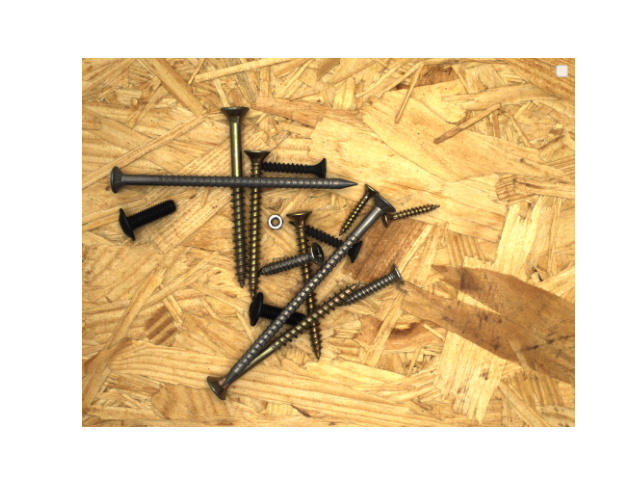

In [7]:
img_path = get_random_image_from_dataset(
    Path('datasets/basic_screw_dataset/images'))
org_image = cv2.imread(img_path, cv2.IMREAD_COLOR)

predicts = model.predict(source=org_image, conf = 0.6)


for result in predicts:
    result_image = org_image.copy()
    boxes = result.obb.xywhr.cpu().numpy()  # type: ignore
    edges = result.obb.xyxyxyxy.cpu().numpy()  # type: ignore
    scores = result.obb.conf.cpu().numpy()  # type: ignore
    labels = result.obb.cls.cpu().numpy()  # type: ignore
    
    fig = plt.figure()

    for box, edge, score, label in zip(boxes, edges, scores, labels):
        pt1, pt2, pt3, pt4 = edge
        x, y, w, h, r = box
        plt.fill(edge[:, 0], edge[:, 1], alpha=0.5, label=f'Class {label} ({score:.2f})')
        plt.arrow((x, y), w * np.cos(r), h * np.sin(r),
                  head_width=0.05, head_length=0.1, fc='red', ec='red', label=f'Angle {r:.2f}')

    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.legend()

-----

好像确实不能梯度下降，也许以后换一种损失函数可以解决问题？